Student's Name and Email Address

Boise State University, Department of Chemistry and Biochemistry

## CHEM 324: PChem Lab {-}
# Worksheet 2: Kinetics of Methylene-Blue RedOx {-}

In [212]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.optimize
from scipy.stats import sem, t, norm
# suppress warnings
import warnings
warnings.filterwarnings('ignore')


base_path = '/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data'

In [213]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a uv-vis .csv file. 
    The format of the file should have two rows of headers and two columns of data (time and absorbance)
    The file may have additional information from the instrument saved at the bottom

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with two columns: time (in seconds) and absorbance (in input units)   
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],header=1,usecols=(0,1)).apply(pd.to_numeric,errors='coerce').dropna()
    data = data[data['Abs']>0.]
    if data.keys()[0] == 'Time (sec)' :
        data = data.rename(columns={'Time (sec)':'time'})
    elif data.keys()[0] == 'Time (min)' :
        data['time'] = data['Time (min)'] * 60
        data = data.drop('Time (min)',axis=1)
    data = data.rename(columns={'Abs':'absorbance'})
    file_dict['data'] = data
    return

def load_data_to_file_list(file_list):
    """
    Given a list of dictionary files, recursively use load_data_to_file_dict to load the data into each of the dictionaries

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to each file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)   
    """
    for f in file_list : 
        if not ('data' in f): load_data_to_file_dict(f)
    return

def plot_file_dict(file_dict, semilog=False, with_fit=False):
    """
    Given a dictionary file of a bomb calorimetry experiment, plot temperature vs. time.

    Input variables:
        file_dict : a dictionary file with 'path' and 'name' keys corresponding to the file to be loaded
        semilog : use a logarithmic scale for the absorbance axis
        with_fit : plot the fitted curve, if present
    
    Action: 
        Plot absorbance vs. time for the selected file 
    """
    fig, ax = plt.subplots()
    if not ('data' in file_dict):
        load_data_to_file_dict(file_dict)
    if semilog :
        plt.semilogy(file_dict['data']['time'],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys(): 
            plt.semilogy(file_dict['data']['time'],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    else:
        plt.plot(file_dict['data']['time'],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys(): 
            plt.plot(file_dict['data']['time'],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

def plot_file_list(file_list,key='',value=[''],semilog=False,with_fit=False):
    """
    Given a list of dictionary files, plot absorbance vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot absorbance vs. time for the selected files  
    """
    if value == '' or key == '':
        file_shortlist = file_list
    else :
        file_shortlist = [f for f in file_list if f[key] in value ]
    fig, ax = plt.subplots()
    for i,f in enumerate(file_shortlist) : 
        color='C'+str(i)
        if not ('data' in f): 
            load_data_to_file_dict(f)
        if semilog :
            plt.semilogy(f['data']['time'],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys(): 
                plt.semilogy(f['data']['time'],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
        else:
            plt.plot(f['data']['time'],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys(): 
                plt.plot(f['data']['time'],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

In [214]:
# @title Functions to fit the data { display-mode: "form" }
def linear(t, a, k, o):
    """ 
    Function that returns a linear decaying function that saturates to an offset
    f(t) = o + a - k * t (for t < a/k) or o (for t > a/k)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    filter = t < a/k
    return o + filter * (a - k * t)

def exponential(t, a, k, o):
    """ 
    Function that returns an exponentially decaying function plus offset
    f(t) = o + a*e^(-k*t)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    return a * np.exp(-k*t) + o

def inverse(t, a, k, o):
    """ 
    Function that returns a inverse decaying function plus offset
    f(t) = o + 1/(1/a + 2*k*t) 

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    return o + 1/(1/a+2*k*t)

# Functions designed for fit the kinetics data
def fit_kinetic(file_dict):
    """ 
    Perform the fit of kinetic decay curves (uv-vis absorption spectra) using non-linear
    functions plus offset. 

    Input parameters: 
    file_dict: a dictionary with information on the file with the data (path and name) and
               adjustable parameters related to the fit:
               time_skip : initial transient regime to remove from the fit
               order: order of the kinetics to fit (zeroth, first, or second)
               MB0, k, offset: starting guess of fitting parameters

    Action: 
           Filter the data by removing the initial time_skip part of the curve
           Fit one of three non-linear regimes according to the specified order (linear, exponential, inverse)
           Save the optimized values of the parameters and their standard errors in file_dict
           Save the fitted curve in the file_dict['data'] DataFrame
    """   
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
        
    filtered_data = file_dict['data'][file_dict['data']['time']>file_dict['time_skip']]
    x = filtered_data['time']
    y = filtered_data['absorbance']

    if file_dict['order'] == 'zeroth' :
        funct = linear
    elif file_dict['order'] == 'first' :
        funct = exponential
    elif file_dict['order'] == 'second' :
        funct = inverse

    p0 = (file_dict['MB0_guess'],file_dict['k_guess'],file_dict['offset_guess'])
    params, cv = scipy.optimize.curve_fit(funct,x,y,p0)

    file_dict['MB0'] = params[0]
    file_dict['MB0_SE'] = np.sqrt(cv[0,0])
    file_dict['k'] = params[1]
    file_dict['k_SE'] = np.sqrt(cv[1,1])
    file_dict['offset'] = params[2] 
    file_dict['offset_SE'] = np.sqrt(cv[2,2])

    file_dict['data']['absorbance_fitted'] = funct(file_dict['data']['time'],params[0],params[1],params[2])


In [215]:
path = "/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data/"

## Task 1: Order of the Reaction with Respect to Methylene Blue {-}

* Visually inspect each of your curves from the first set of experiments, one by one. In fitting the different kinetic models, you will realize that the very first part of your experiment does not fit well with any of the models. This is because the transient regimes that occurs at the beginning of the experiment as you mix your reactants has a complicated behavior that does involve mass transport in the liquid and does not follow any of the steady-state kinetic models that you have studied. As part of this task, adjust the transient time (`time_skip`) until at least one of the fits appears reasonable. Report this transient time with your comments and keep it in mind for the later tasks. In the process, make sure that the starting values of the parameters used for the non-linear fit are reasonable. You can perform these checks on the Kinetics_ModelingData.ipynb notebook, but make sure to add the appropriate values to the following dictionaries. NOTE: feel free to add more dictionaries, if you performed more than four experiments.

In [216]:
setA_run1 = {'path': path, 'name': 'SetA_T1.csv', 'label': 'Run1', 'set': 'A', '[MB]': 2.00E-05, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setA_run2 = {'path': path, 'name': 'SetA_T2.csv', 'label': 'Run2', 'set': 'A', '[MB]': 1.50E-05, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setA_run3 = {'path': path, 'name': 'SetA_T3.csv', 'label': 'Run3', 'set': 'A', '[MB]': 1.00E-05, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setA_run4 = {'path': path, 'name': 'SetA_T4.csv', 'label': 'Run4', 'set': 'A', '[MB]': 5.00E-06, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setA_run5 = {'path': path, 'name': 'SetA_T5.csv', 'label': 'Run5', 'set': 'A', '[MB]': 3.00E-06, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 10 }
setA_run6 = {'path': path, 'name': 'SetA_T6.csv', 'label': 'Run6', 'set': 'A', '[MB]': 0.00E-06, '[AA]': 0.1, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 1 }

setA_files = [setA_run1, setA_run2, setA_run3, setA_run4, setA_run5, setA_run6]

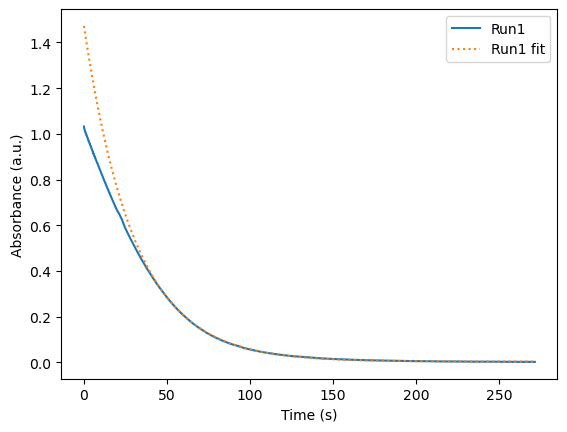

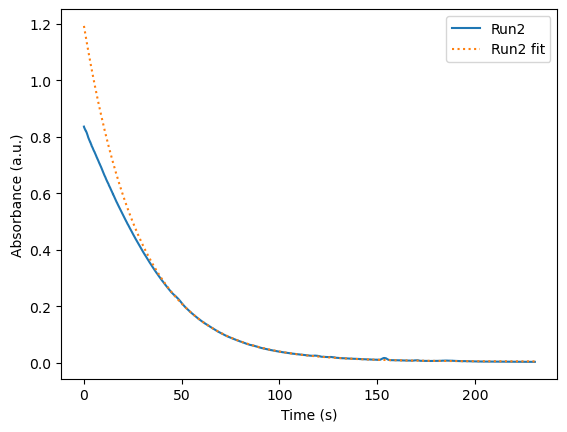

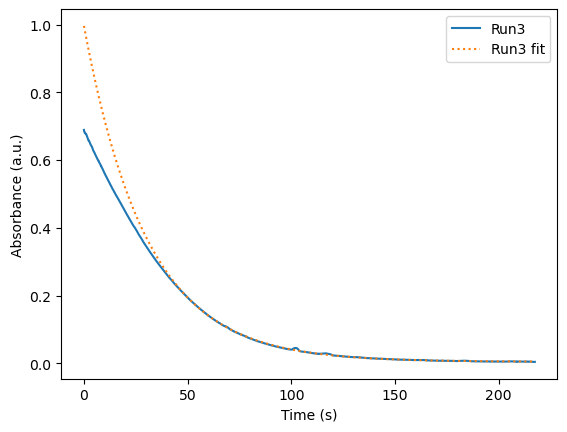

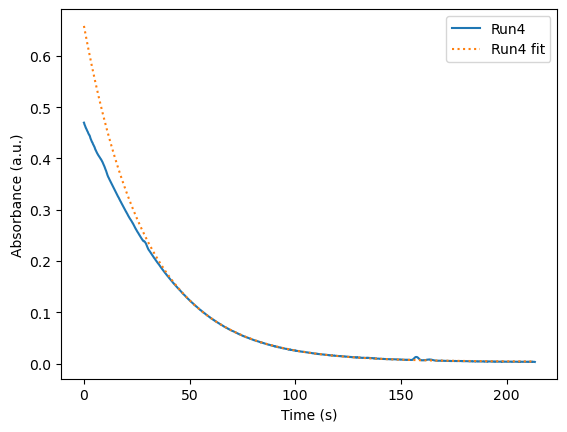

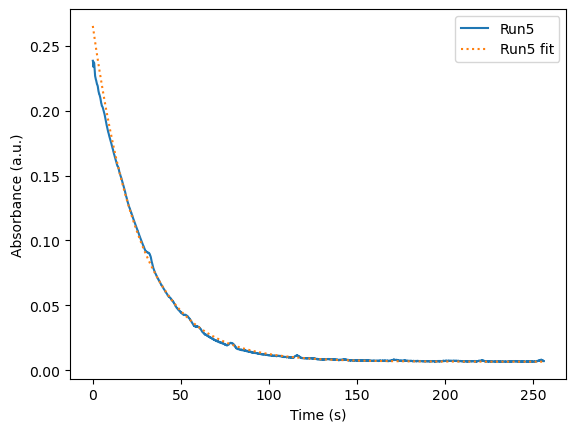

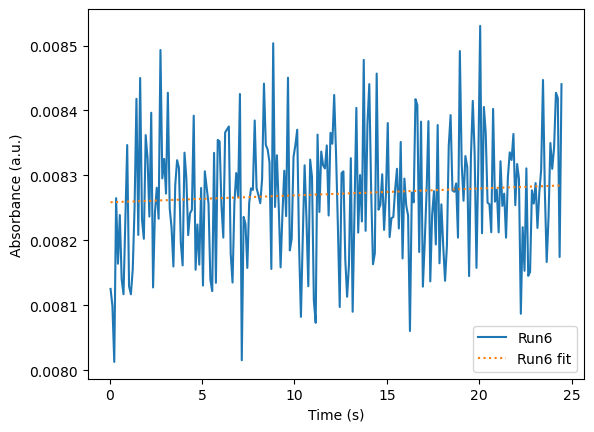

In [217]:
# Visualize each file in Set A with fit curves and R² values
for file in setA_files:
    load_data_to_file_dict(file)  # Load data if not already loaded
    fit_kinetic(file)  # Fit the kinetic data
    plot_file_dict(file, semilog=False, with_fit=True)  # Plot the data and the fit

* Fit the absorbance decay curve for one of the experiments in Set A with three alternative models, each corresponding to a different kinetic order with respect to methylene blue. From the three plots verify that the model that best describes the kinetics is the first order one.

The R² for the linear fit is 0.9800
The R² for the exponential fit is 0.9972
The R² for the inverse fit is 0.9733


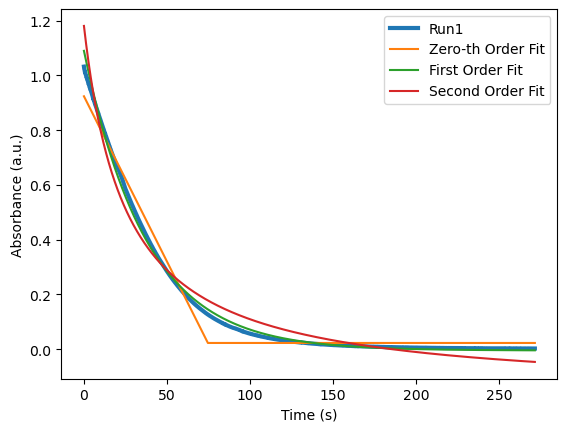

In [218]:
 file_dict = setA_run1  # you can choose any run you want here
load_data_to_file_dict(file_dict)

# Filter the data according to time_skip
time_skip = 0
filtered_data = file_dict['data'][file_dict['data']['time'] > time_skip]
x = filtered_data['time']
y = filtered_data['absorbance']
TSS = np.sum((y - y.mean()) ** 2)  # This is the total sum of squares
plt.plot(x, y, linewidth=3, label=file_dict['label'])  # Plot the experimental curve

# Zero-th order model, linear fit plus offset
funct = linear
p0 = (0.2, 0.001, 0.051)  # Initial guesses for the parameters
params, cv = scipy.optimize.curve_fit(funct, x, y, p0)
y_fit = funct(x, params[0], params[1], params[2])
plt.plot(x, y_fit, label='Zero-th Order Fit')
RSS = np.sum((y - y_fit) ** 2)  # Residual Sum of Squares
R2 = 1. - RSS / TSS
print(f'The R² for the {funct.__name__} fit is {R2:6.4f}')

# First order model, exponential fit plus offset
funct = exponential
p0 = (0.4, 0.1, 0.05)  # Initial guesses for the parameters
params, cv = scipy.optimize.curve_fit(funct, x, y, p0)
y_fit = funct(x, params[0], params[1], params[2])
plt.plot(x, y_fit, label='First Order Fit')
RSS = np.sum((y - y_fit) ** 2)  # Residual Sum of Squares
R2 = 1. - RSS / TSS
print(f'The R² for the {funct.__name__} fit is {R2:6.4f}')

# Second order model, inverse fit plus offset
funct = inverse
p0 = (0.1, 0.01, 0.05)  # Initial guesses for the parameters
params, cv = scipy.optimize.curve_fit(funct, x, y, p0)
y_fit = funct(x, params[0], params[1], params[2])
plt.plot(x, y_fit, label='Second Order Fit')
RSS = np.sum((y - y_fit) ** 2)  # Residual Sum of Squares
R2 = 1. - RSS / TSS
print(f'The R² for the {funct.__name__} fit is {R2:6.4f}')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (a.u.)')
plt.show()

* Describe the model that best fits your experiment, e.g. qualitatively and/or by comparing the $R^2$ coefficients of the different fits. Remember that the coefficient of determination can be computed as $R^2=1-RSS/TSS$, where $$RSS = \sum_i (y_i^{fit} - y_i)^2$$ is the residual sum of squares while $$TSS=\sum_i (y_i - \bar{y})^2$$ is the total sum of squares. Add any additional comment or explanation.

Best fit model based on R^2 would be the exponential fit (R^2 = 0.9972); thus the degradation of Methylene Blue appears to follow first order kinetics. The other fits are also relatively strong; the zeroeth shows considerable deviation, but still strong R^2.

* Knowing that methylene blue is the only chemical in the reaction that absorbs at around 665 nm, provide a plausible explanation of the offset observed in the decays of methylene blue.

The offset observed @650nm could be due to contamination, incomplete degradation, impurities in the cuvette might also scatter light; however, I doubt this contributes much. Similar to the TA experiment, there might be some chemical explanation where you have residual dye or some byproduct formed that continue to absorb.

## Task 2: Rate Constant in Flooding Conditions {-}

The first set of experiments (Set A) was performed under flooding conditions, i.e. with a much larger pH and concentration of ascorbic acid, [AA], than the concentration of methylene blue, [MB]. Under these conditions, the kinetics is first order in [MB] and the fit using an expontential function plus offset should provide a good estimate of the effective decay rate.
* Fit the absorbance decay curves for the experiments. Plot the decay curves together with the fitted curves. 

In [219]:
for file in setA_files:
    fit_kinetic(file)

For plotting, you can use the utilities provided with this notebook: 
* `plot_file_dict()` allows you to plot directly one of the experiments by passing its file dictionary. You can specify if you want a semilog or a linear scale for the y axis. You can also choose to add the fitted curve together with the experimental one (provided you have run the fit). 
* `plot_file_list()` takes a list of files in input and allows you to plot all the files in the set at once. You can select a subset of files by specifying a key and the corresponding value. 

If you want to modify the appearance of these plots, you may need to change the functions definitions or generate the plots by yourself.

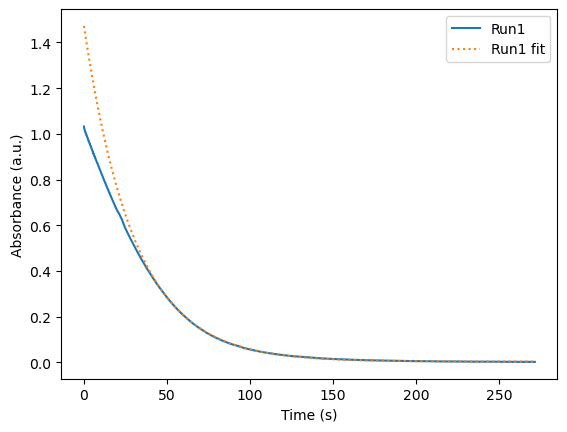

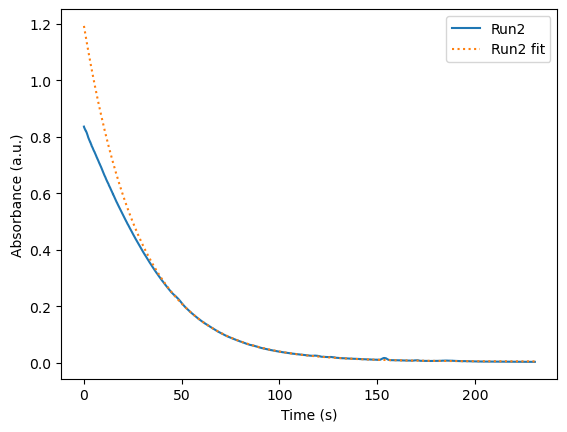

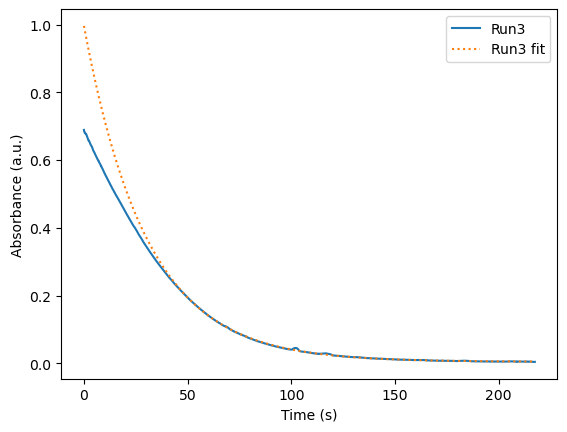

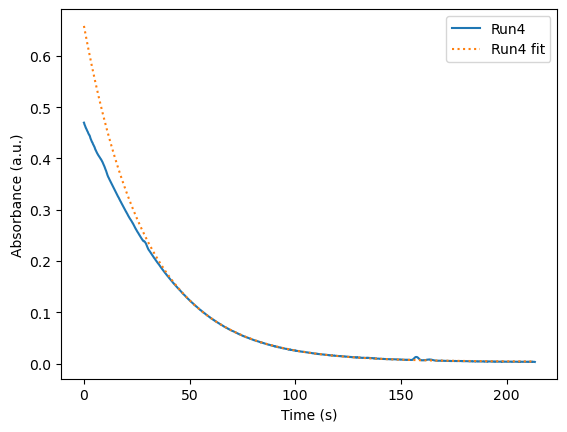

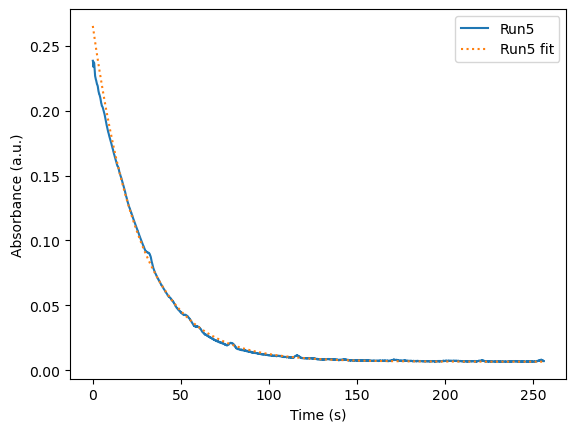

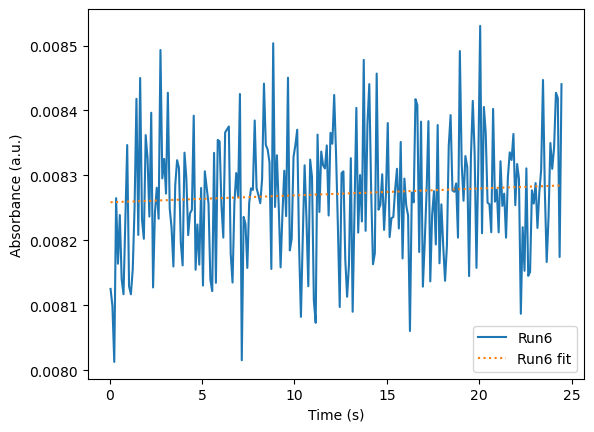

In [220]:
plot_file_dict(setA_run1,semilog=False,with_fit=True)
plot_file_dict(setA_run2, semilog=False, with_fit=True)
plot_file_dict(setA_run3, semilog=False, with_fit=True)
plot_file_dict(setA_run4, semilog=False, with_fit=True)
plot_file_dict(setA_run5, semilog=False, with_fit=True)
plot_file_dict(setA_run6, semilog=False, with_fit=True)

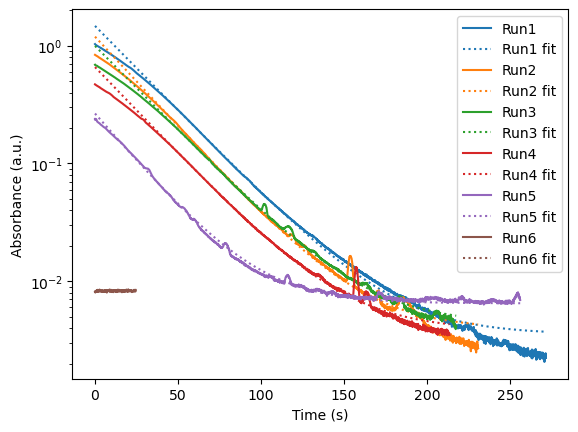

In [221]:
plot_file_list(setA_files,semilog=True,with_fit=True)

* Report a table with the fitted values of the decay rate for each run, together with the relevant information about the experiment. You can generate this table easily from the list of files, by converting it into a `Pandas.DataFrame`. You can then select the subset of columns you need to report and print them as a markdown table (or in any other format you like). The following command shows you how to select some of the relevant columns (you can add others). 

In [222]:
# Exclude Run6 from the analysis
setA_files = [setA_run1, setA_run2, setA_run3, setA_run4, setA_run5]

# Create a DataFrame from setA_files
setA_data = pd.DataFrame(setA_files)

# Select relevant columns for the table
table = setA_data[['label', '[MB]', 'k', 'k_SE']]

# Manually include units in the printed table
table_with_units = table.to_markdown(index=False)

# Adjust table formatting and align the columns properly
table_with_units = table_with_units.replace('[MB]', '[MB] (M)').replace('k', 'k (1/s)').replace('k_SE', 'k_SE (1/s)')

# Manually align columns and headers
table_with_units = table_with_units.replace("|", "| ").replace(" |", " | ")

# Print the final table with aligned units
print(table_with_units)


|  label   |      [MB] (M) |           k (1/s) |          k (1/s)_SE |  
| :--------| --------:| ----------:| ------------:| 
|  Run1    |   2e-05   |   0.03313   |   2.158e-05   |  
|  Run2    |   1.5e-05 |   0.0351711 |   4.34519e-05 |  
|  Run3    |   1e-05   |   0.033083  |   4.49792e-05 |  
|  Run4    |   5e-06   |   0.0339956 |   5.0942e-05  |  
|  Run5    |   3e-06   |   0.0378157 |   5.13263e-05 |  


You can copy and past the output above into a markdown cell. NOTE: make sure you manually adjust the final table to clean column labels, to add units, to fix the number of figures of the reported numbers, etc.

|  label   |      [MB] (M) |           k (1/s) |          k (1/s)_SE |
| :--------| --------:| ----------:| ------------:|
|  Run1    |   2e-05   |   0.03313   |   2.158e-05   |
|  Run2    |   1.5e-05 |   0.0351711 |   4.34519e-05 |
|  Run3    |   1e-05   |   0.033083  |   4.49792e-05 |
|  Run4    |   5e-06   |   0.0339956 |   5.0942e-05  |
|  Run5    |   3e-06   |   0.0378157 |   5.13263e-05 |



* Do the effective decay rates that you determine depend on precisely konwing the starting concentration of methylene blue? Why or why not?

The effective decay rates are related to the concentration of methylene blue at a give time according to: d[MB]/dt = -k[MB], where the rate constant (k) is independent of concentration; however, the initial conc. of MB determines the initial rate of reaction; regardless, exact MB concentration isn't required as the rate constant should remain independent of concentration provided the first-order assumption holds. The error in the rate constants (k_SE) suggest that the fitting is less accurate for the lower concentrations (likely due to measurement error).

* Compute and report your best estimate for the effective decay rate and try to address these points in your discussion of the results:
  * Do your estimates in the four runs have the same accuracy? 
  * If not, which one is less accurate? Why? 

In [223]:

k_values = [0.03313, 0.0351711, 0.033083, 0.0339956, 0.0378157]
k_SE_values = [2.158e-05, 4.345e-05, 4.498e-05, 5.094e-05, 5.133e-05]
k_avg = sum(k_values) / len(k_values)

k_best = 0.03313
k_SE = 2.158e-05
z_score = 1.96
CI = z_score * k_SE

# Print the confidence interval in ± format
print(f"± {CI:.5e} 1/s")
# Print the average decay rate
print(f"Average effective decay rate (k_avg): {k_avg:.6f} 1/s")

print(f"The best estimate of the effective decay rate for MB redox under flooding conditions is {0.03313} 1/s")
print(f"This estimate was obtained under the following conditions: [AA] = {0.025} M and [HCl] = {0.06} M")
print(f"The 95% confidence interval on the estimated decay rate is ± {CI:.5e} 1/s")

± 4.22968e-05 1/s
Average effective decay rate (k_avg): 0.034639 1/s
The best estimate of the effective decay rate for MB redox under flooding conditions is 0.03313 1/s
This estimate was obtained under the following conditions: [AA] = 0.025 M and [HCl] = 0.06 M
The 95% confidence interval on the estimated decay rate is ± 4.22968e-05 1/s


Estimates are relatively close for second and third run and closer the fourth (given the k_SE); the first run had the least error (roughly half of the subsequent runs); the increase in uncertainty with subsequent runs at lower MB conc. can be attributed to measurement error and procedural error/limitation of volumetric instruments when dispensing lower concentration samples.

## Task 3: Reaction Order with Respect to Ascorbic Acid {-}

In the second set of experiments (Set B) you kept $[MB]$ fixed and varied the concentration of ascorbic acid. However, your UV/Vis apparatus is still tracking the behavior of the methylene blue. The effective decay rate of MB will be given by $k_{eff}^B=k[MB]^m[AA]^n[H^+]^p$, where the $[MB]$ and $[H^+]$ terms will be the same in the four runs. By fitting the effective decay rate as a function of $[AA]$ we can determine the reaction order with respect to the second redox compound. 

* Manually inspect each of your files, one by one, and adjust the transient time (`time_skip`), the order of the fit, and the initial guesses of the fit parameters. Report the correct values in the dictionaries below for each of your runs. NOTE: you can add more dictionaries if you performed more than four experiments in this set.

In [224]:
setB_run1 = {'path': path, 'name': 'SetB_T1.csv', 'label': 'Run1', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.04, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}
setB_run2 = {'path': path, 'name': 'SetB_T2.csv', 'label': 'Run2', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.025, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}
setB_run3 = {'path': path, 'name': 'SetB_T3.csv', 'label': 'Run3', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.015, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}
setB_run4 = {'path': path, 'name': 'SetB_T4.csv', 'label': 'Run4', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.01, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}
setB_run5 = {'path': path, 'name': 'SetB_T5.csv', 'label': 'Run5', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.005, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}
setB_run6 = {'path': path, 'name': 'SetB_T6.csv', 'label': 'Run6', 'set': 'B', '[MB]': 1.5e-05, '[AA]': 0.0, '[HCl]': 0.06, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50}

setB_files = [setB_run1, setB_run2, setB_run3, setB_run4, setB_run5, setB_run6]

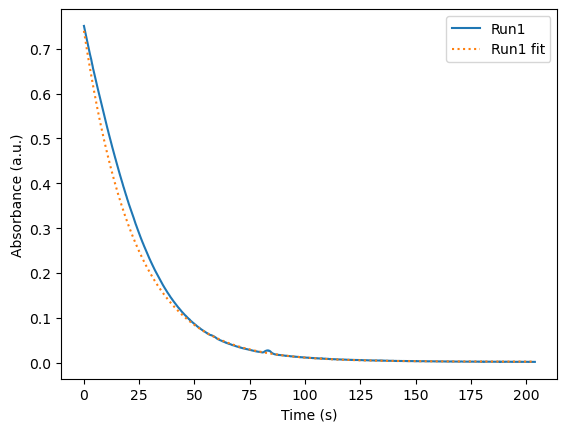

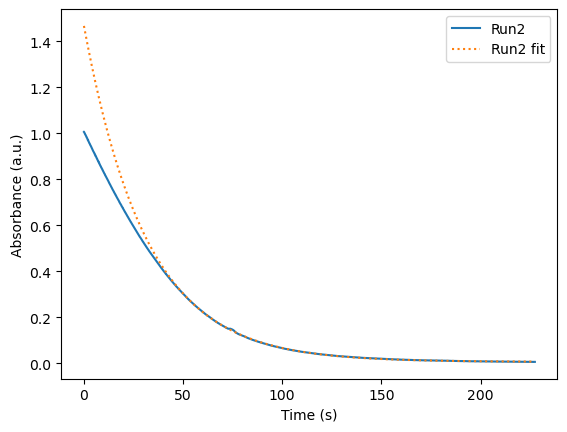

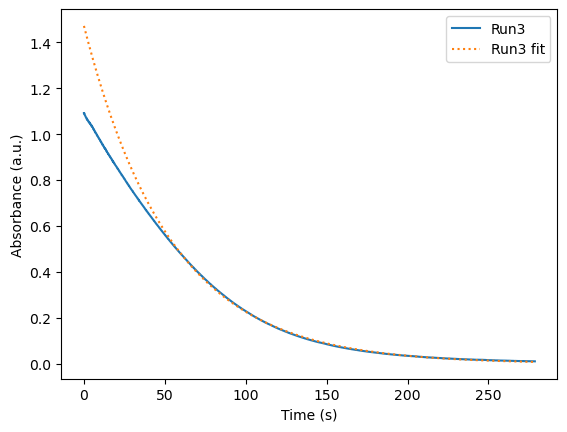

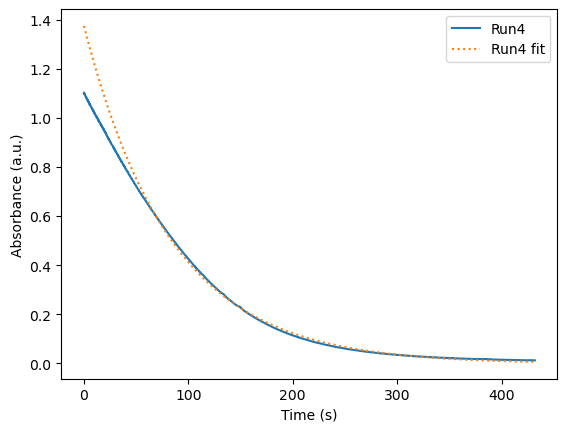

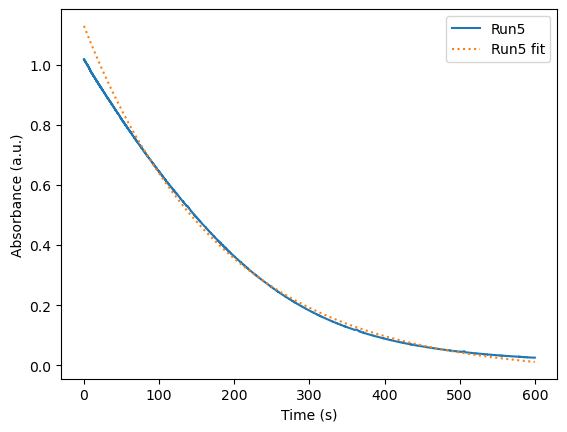

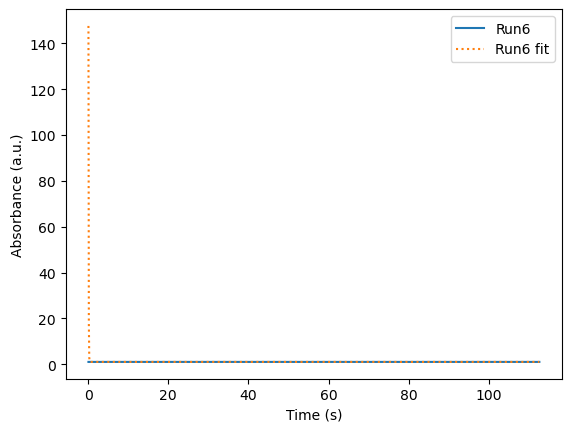

In [225]:

for file in setB_files:
    load_data_to_file_dict(file)
    fit_kinetic(file)
    plot_file_dict(file, semilog=False, with_fit=True)

In [233]:


# Create a DataFrame from setA_files
setB_data = pd.DataFrame(setB_files)

# Select relevant columns for the table
table = setB_data[['label', '[AA]', 'k', 'k_SE']]

# Manually include units in the printed table
table_with_units = table.to_markdown(index=False)

# Adjust table formatting and align the columns properly
table_with_units = table_with_units.replace('[AA]', '[AA] (M)').replace('k', 'k (1/s)').replace('k_SE', 'k_SE (1/s)')

# Manually align columns and headers
table_with_units = table_with_units.replace("|", "| ").replace(" |", " | ")

# Print the final table with aligned units
print(table_with_units)

|  label   |     [AA] (M) |             k (1/s) |            k (1/s)_SE |  
| :--------| -------:| ------------:| --------------:| 
|  Run1    |    0.04  |    0.0440268  |     0.00012006  |  
|  Run2    |    0.025 |    0.0318843  |     2.32822e-05 |  
|  Run3    |    0.015 |    0.0187192  |     2.29888e-05 |  
|  Run4    |    0.01  |    0.0120182  |     1.85347e-05 |  
|  Run5    |    0.005 |    0.00549561 |     9.55997e-06 |  
|  Run6    |    0     |   21.6109     |   inf           |  


* Fit the exponential decays of the different runs and extract the effective decay rates. Report your experimental curves with their corresponding fits.

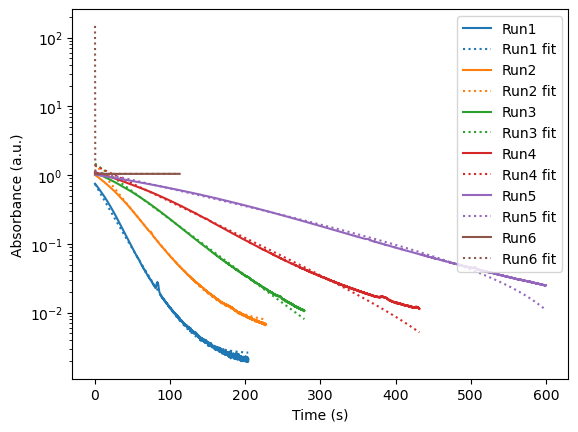

In [227]:
plot_file_list(setB_files,semilog=True,with_fit=True)

* Report a table with the fitted values of the decay rate for each run, together with the relevant information about the experiment. You can generate this table easily from the list of files, by converting it into a `Pandas.DataFrame`. You can then select the subset of columns you need to report and print them as a markdown table (or in any other format you like). The following command shows you how to select some of the relevant columns (you can add others). NOTE: also in this case, make sure you adjust the final table so that it has clean labels, units, currect number of significant figures, etc. 

In [228]:
setB_data = pd.DataFrame(setB_files)
print(setB_data[['label','[AA]','k','k_SE']].to_markdown(index=False))

| label   |   [AA] |           k |          k_SE |
|:--------|-------:|------------:|--------------:|
| Run1    |  0.04  |  0.0440268  |   0.00012006  |
| Run2    |  0.025 |  0.0318843  |   2.32822e-05 |
| Run3    |  0.015 |  0.0187192  |   2.29888e-05 |
| Run4    |  0.01  |  0.0120182  |   1.85347e-05 |
| Run5    |  0.005 |  0.00549561 |   9.55997e-06 |
| Run6    |  0     | 21.6109     | inf           |


| label   |   [AA] |       k_fit |          k_SE |
|:--------|-------:|------------:|--------------:|
| Run1    |  0.1   |   0.0357727 |   9.03933e-06 |
| Run2    |  0.01  |   0.0279188 |   1.8088e-05  |
| Run3    |  0.001 |   0.0131579 |   1.54417e-05 |
| Run4    |  0     | 144.173     | inf           |

* Plot the behavior of $\log(k_{eff}^B)$ vs. $\log([AA])$, and fit it with a linear regression model. NOTE: we need to skip the run with no ascorbic acid. The slope of the plot should provide an estimate for the order $n$ of the reaction wrt [AA]. 
  * Is the order of the reaction the one you expected? Why or why not?

The order of the reaction with respect to [AA] is 1.016207433022413


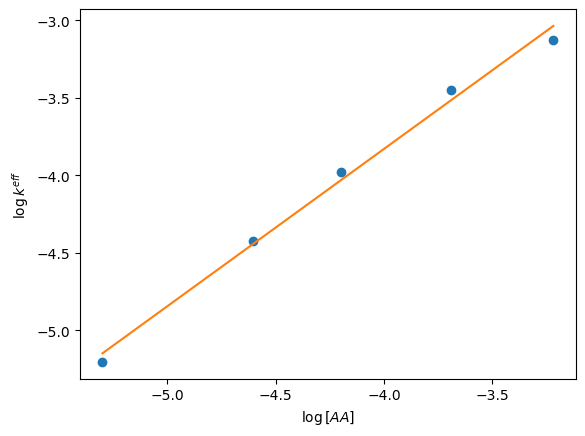

In [229]:
# skip the point with [AA] = 0 (its log() is not defined)
filtered_data = setB_data[setB_data['[AA]']>0.]
#
x=np.log(filtered_data['[AA]'].values.reshape(-1,1))
y=np.log(filtered_data['k'].values)
aa_order=LinearRegression()
aa_order.fit(x,y)
print("The order of the reaction with respect to [AA] is {}".format(aa_order.coef_[0]))
plt.plot(x,y,'o')
plt.plot(x,aa_order.predict(x))
plt.xlabel('$\log{[AA]}$')
plt.ylabel('$\log{k^{eff}}$')
plt.show()

YOUR COMMENTS HERE

## Task 4: Reaction Order with Respect to pH {-}

In the second set of experiments (Set B) you kept $[MB]$ fixed and varied the concentration of HCl, i.e. you changed the pH of the solution. However, your UV/Vis apparatus is still tracking the behavior of the methylene blue. The effective decay rate of MB will be given by $k_{eff}^C=k[MB]^m[AA]^n[H^+]^p$, where the $[MB]$ and $[AA]$ terms will be the same in the four runs. By fitting the effective decay rate as a function of $[H^+]$ or pH we can determine the reaction order with respect to a potential component of the redox reaction. 

* Manually inspect each of your files, one by one, and adjust the transient time (`time_skip`), the order of the fit, and the initial guesses of the fit parameters. Report the correct values in the dictionaries below for each of your runs. NOTE: you can add more dictionaries if you performed more than four experiments in this set. **For this task you will need to compute the $pH$ of your experiments and add the correct values to the dictionaries.**

In [230]:
setC_run1 = {'path':path, 'name':'SetCrun1.csv', 'label':'Run1', 'set':'C', '[MB]': 0.1, '[AA]': 0.1, '[HCl]': 0.1, 'pH': 1, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setC_run2 = {'path':path, 'name':'SetCrun2.csv', 'label':'Run2', 'set':'C', '[MB]': 0.1, '[AA]': 0.1, '[HCl]': 0.01, 'pH': 2, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setC_run3 = {'path':path, 'name':'SetCrun3.csv', 'label':'Run3', 'set':'C', '[MB]': 0.1, '[AA]': 0.1, '[HCl]': 0.001, 'pH': 3, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }
setC_run4 = {'path':path, 'name':'SetCrun4.csv', 'label':'Run4', 'set':'C', '[MB]': 0.1, '[AA]': 0.1, '[HCl]': 0.0, 'pH': 4, 'order': 'first', 'MB0_guess': 0.4, 'k_guess': 0.2, 'offset_guess': 0.05, 'time_skip': 50 }

setC_files = [setC_run1, setC_run2, setC_run3, setC_run4]

* Fit the exponential decays of the different runs and extract the effective decay rates. 

In [231]:
for file in setC_files:
    fit_kinetic(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data/SetCrun1.csv'

* Report a table with the fitted values of the decay rate for each run, together with the relevant information about the experiment. You can generate this table easily from the list of files, by converting it into a `Pandas.DataFrame`. You can then select the subset of columns you need to report and print them as a markdown table (or in any other format you like). The following command shows you how to select some of the relevant columns (you can add others). NOTE: also in this case, make sure you adjust the final table so that it has clean labels, units, currect number of significant figures, etc. 

In [ ]:
setC_data = pd.DataFrame(setC_files)
print(setC_data[['label','[HCl]','[AA]','pH','k','k_SE']].to_markdown(index=False))

| label   |   [HCl] |   [AA] |   pH |          k |        k_SE |
|:--------|--------:|-------:|-----:|-----------:|------------:|
| Run1    |   0.1   |    0.1 |    1 | 0.0363349  | 2.58731e-05 |
| Run2    |   0.01  |    0.1 |    2 | 0.0225728  | 1.11192e-05 |
| Run3    |   0.001 |    0.1 |    3 | 0.0362645  | 0.000136833 |
| Run4    |   0     |    0.1 |    4 | 0.00145945 | 3.72351e-06 |

* Plot the behavior of $\log(k_{eff}^C)$ vs. $pH$, the slope of the plot should provide an estimate for the order of the reaction wrt the concentration of protons in solution.
  * Is there a clear order of the reaction with respect to $pH$? What could be the role of pH?

In [ ]:
x=setC_data['pH'].values.reshape(-1,1)
y=np.log(setC_data['k'].values)
pH_order=LinearRegression()
pH_order.fit(x,y)
print("The order of the reaction with respect to pH is {}".format(pH_order.coef_[0]))
plt.plot(x,y,'o')
plt.plot(x,pH_order.predict(x))
plt.xlabel('$pH$')
plt.ylabel('$\log{k^{eff}}$')
plt.show()

YOUR COMMENTS HERE

In [ ]:
# This cell is used to allow Google Colab to install the tools to convert the notebook to a pdf file
# Un-comment the following lines when you are ready to export the pdf 
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

In [ ]:
# Use this command to convert the finished worksheet into a pdf 
# NOTE : you may want to change the path of the file, if you are working in a different folder of the Google Drive
#!jupyter nbconvert --no-input --to PDF "/content/drive/MyDrive/Colab Notebooks/Kinetics_Worksheet.ipynb"